In [ ]:
# Model calling and intial setup
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 
import warnings
warnings.filterwarnings("ignore") 

load_dotenv()
# Load env
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
AZURE_BASE_URL = os.getenv("AZURE_BASE_URL")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_CHAT_DEPLIOYMENT_NAME = os.getenv("AZURE_CHAT_DEPLIOYMENT_NAME")

parser = StrOutputParser()

llm_gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash" , api_key= GOOGLE_API_KEY)

llm_openai = AzureChatOpenAI(
    model="gpt-4o-mini",                         
    deployment_name=AZURE_CHAT_DEPLIOYMENT_NAME ,  # deployment name in Azure
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_BASE_URL,
    api_version="2024-02-01"
    )
llm_openai.invoke("What are your creater, also what type of LLM are you").content
# llm_gemini.invoke("who is father of india").content

### Simple First Parallel Workflows

In [ ]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict

class BatmanState(TypedDict):
    runs : int
    balls : int
    fours : int
    sixes : int
    sr : float
    bpb : float
    boudary_percantage : float
    summary : str

# InvalidUpdateError : In parallel workflow we can't send whole state, send partial state
def get_sr(state:BatmanState)->BatmanState:
    sr = (state['runs'] / state['balls'])*100
    # state['sr'] = sr Can't do that : InvalidUpdateError
    
    return {"sr" : sr} 

def get_bpb(state:BatmanState)->BatmanState:
    bpb = state['balls'] / (state['fours'] + state['sixes']) 
    # state['bpb'] = bpb
    
    return {"bpb" : bpb} # This is better, work with everytime

def get_bp(state:BatmanState)->BatmanState:
    bp = ((state['fours'] + state['sixes']) / state['balls'])*100
    # state['boudary_percantage'] = bp
    
    return {"boudary_percantage" : bp}

def get_summary(state:BatmanState)->BatmanState:
    summary = f"sr : {state['sr']}\nbpb : {state['bpb']}\nBp: {state['boudary_percantage']}"
    state['summary'] = summary
    return state

graph = StateGraph(BatmanState)

# Add Node
graph.add_node("Get_sr" ,get_sr)
graph.add_node("Get_bpb" , get_bpb)
graph.add_node("Get_bp" , get_bp)
graph.add_node("Summary" , get_summary)

# Add Edges
graph.add_edge(START , "Get_sr")
graph.add_edge(START , "Get_bpb")
graph.add_edge(START , "Get_bp")

graph.add_edge("Get_sr" , "Summary")
graph.add_edge("Get_bpb" , "Summary")
graph.add_edge("Get_bp" , "Summary")

graph.add_edge("Summary" , END)

first_workflow = graph.compile()

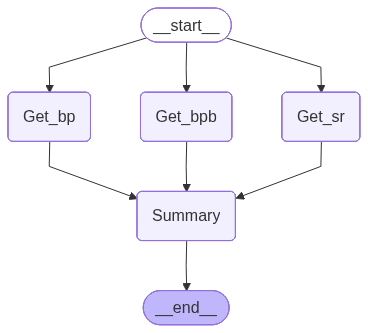

In [28]:
from IPython.display import Image
Image(first_workflow.get_graph().draw_mermaid_png())

In [31]:
print(first_workflow.invoke({"runs":55 , "balls":23 , "fours" : 4 , "sixes":4})['summary'])

sr : 239.1304347826087
bpb : 2.875
Bp: 34.78260869565217


### LLM Parellel workflow